In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import shutil
from IPython import display
import os

import meep as mp

import sys
sys.path.append('../../lib')
from ataitmeep import *

from lightlab.util import io
from lightlab.util.data import Spectrum, FunctionBundle, MeasuredFunction

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
io.dataHome /= 'reflectors'

In [3]:
from make_tomeep import give_geom
give_geom()

layer 1 not in meep mapping
layer 2 not in meep mapping


(Vector3<31.0, 15.0, 0.0>,
  <meep.geom.Prism at 0x11a42f400>])

In [6]:
# Define the system
resolution = 20 # pixels/um

dpml = 1
sm_width = 0.35

lcen = 1.22
fcen = 1/lcen
df = 0.05*fcen
nfreq = 1000

# Load it
cell, geometry = give_geom()

# sources = [mp.EigenModeSource(src=mp.GaussianSource(fcen,fwidth=df),
#                                   size=mp.Vector3(0, .35),
#                                   center=mp.Vector3(-cell.x/2+dpml, 0),
#                                   eig_match_freq=True)]
sources = [mp.Source(mp.GaussianSource(fcen, fwidth=df), 
                     component=mp.Ez,
                     center=mp.Vector3(-cell.x/2+dpml, 0),
                     size=mp.Vector3(0, sm_width))]

sim = mp.Simulation(resolution=resolution,
                    cell_size=cell,
                    boundary_layers=[mp.PML(dpml)],
                    sources=sources,
                    geometry=geometry,
                    symmetries=[mp.Mirror(mp.Y, phase=1)],
                    progress_interval=1e6,
                   )

def livefield(sim):
    liveplot(sim, mp.Ez)
    
# p1_region = mp.FluxRegion(volume=p1)
# flux1 = sim.add_flux(fcen,0,1,p1_region)

layer 1 not in meep mapping
layer 2 not in meep mapping


-----------
Initializing structure...
run 0 finished at t = 0.0 (0 timesteps)


Vector3<31.0, 15.0, 0.0>

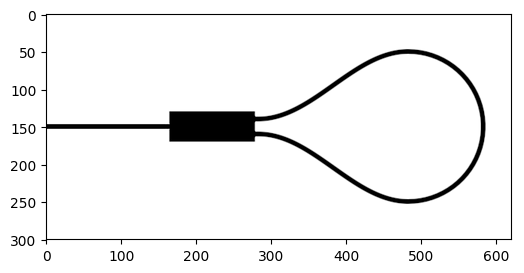

In [18]:
show_geometry(sim)
cell

KeyboardInterrupt: 

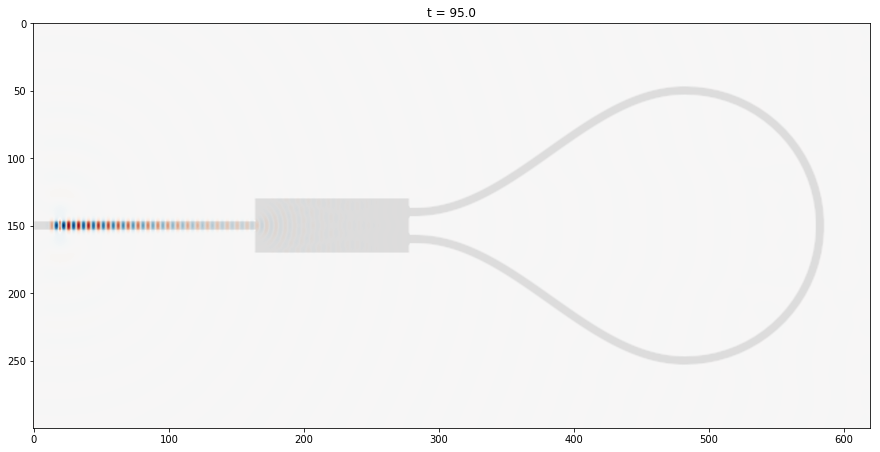

In [19]:

def plot_sim(until=200):
    sim.reset_meep()
    shutil.rmtree('outputs', ignore_errors=True)
    sim.use_output_directory('outputs')
    sim.run(
            mp.at_beginning(livefield),
            mp.at_every(5, livefield),
            mp.at_every(1, mp.output_png(mp.Ez, "-Zc dkbluered")),
            mp.to_appended("ez", mp.at_every(0.6, mp.output_efield_z)),
            until=until)
    # now make the gif
#     subprocess.check_call(['convert', 'outputs/ez-*.png', 'ez.gif'])
#     subprocess.check_call(['open', '-a', 'Safari', 'ez.gif'])

plt.figure(figsize=(15, 8))
plot_sim(300)

In [7]:
subprocess.check_call(['convert', 'outputs/ez-*.png', 'ez.gif'])
subprocess.check_call(['open', '-a', 'Safari', 'ez.gif'])

0

In [11]:
wl = 1 / flux_freqs
# Ok first do the straight waveguide
def do_baseline():
    
    straight_geometry = [mp.Block(mp.Vector3(cell.x, sm_width, 1e20),
                                 center=mp.Vector3(0, 0),
                                 material=mp.Medium(epsilon=12))]
    sim = mp.Simulation(cell_size=cell,
                        boundary_layers=[mp.PML(dpml)],
                        geometry=straight_geometry,
                        sources=sources,
                        resolution=resolution,
                        symmetries=[mp.Mirror(mp.Y, phase=1)],
                        progress_interval=1e6)
    sim.reset_meep()

    # Now put in some flux monitors. Make sure the pulse source was selected
    # reflected flux
    refl_fr = mp.FluxRegion(center=mp.Vector3(-cell.x / 2 + dpml + .5,0,0), size=mp.Vector3(0,sm_width,0))                            
    refl = sim.add_flux(fcen, df, nfreq, refl_fr)

    # transmitted flux
    tran_fr = mp.FluxRegion(center=mp.Vector3(cell.x / 2 - dpml, 0,0), size=mp.Vector3(0,sm_width,0))
    tran = sim.add_flux(fcen, df, nfreq, tran_fr)

    # Do it
    monitor_pt = mp.Vector3(cell.x/2-dpml-0.5,0)
    sim.run(mp.at_beginning(livefield),
            mp.at_every(5, livefield),    
            until_after_sources=mp.stop_when_fields_decayed(50,mp.Ez, monitor_pt,1e-3))

    # for normalization run, save flux fields data for reflection plane
    straight_refl_data = sim.get_flux_data(refl)
    # transmission flux. Note this is entirely different purpose than the above line
    # This one is to normalize power. the other was to negate forward-propagating wave
    straight_tran_flux = mp.get_fluxes(tran)
    return straight_refl_data, straight_tran_flux

straight_refl_data, straight_tran_flux = do_baseline()  # comment this when you dont need to do it again

run 0 finished at t = 450.0 (18000 timesteps)


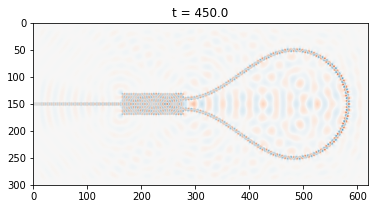

In [9]:
def do_trial(straight_refl_data, with_geometry=geometry, do_live=True):
    sim = mp.Simulation(cell_size=cell,
                        boundary_layers=[mp.PML(dpml)],
                        geometry=with_geometry,
                        sources=sources,
                        resolution=resolution,
                        symmetries=[mp.Mirror(mp.Y, phase=1)],
                        progress_interval=1e6,
                       )
    sim.reset_meep()
    # reflected flux
    refl_fr = mp.FluxRegion(center=mp.Vector3(-cell.x / 2 + dpml + .5,0,0), size=mp.Vector3(0,sm_width,0))                            
    refl = sim.add_flux(fcen, df, nfreq, refl_fr)
    # for normal run, load negated fields to subtract incident from refl. fields
    sim.load_minus_flux_data(refl, straight_refl_data)

    monitor_pt = mp.Vector3(0,0)
    run_args = (mp.at_beginning(livefield), mp.at_every(5, livefield),) if do_live else tuple()
    sim.run(*run_args,    
#             until_after_sources=mp.stop_when_fields_decayed(50,mp.Ez, monitor_pt,1e-5),
            until=450)
    return refl

refl = do_trial(straight_refl_data)
bend_refl_flux = np.array(mp.get_fluxes(refl))
flux_freqs = np.array(mp.get_flux_freqs(refl))

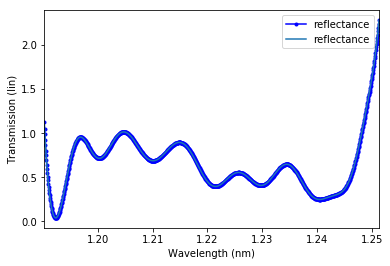

In [13]:

refl2 = bend_refl_flux
# refl2 = np.convolve(bend_refl_flux, np.ones(60)/60, mode='same')
Rs = -refl2/np.array(straight_tran_flux)
plt.plot(wl,Rs,'b.-',label='reflectance')
# plt.plot(wl,1-Rs,'g-',label='loss')
# plt.axis([1.0, 1.44, 0, 1])
ref_spct = Spectrum(wl, Rs, inDbm=False)
ref_spct.simplePlot(label='reflectance')
# plt.ylim([0,1])
# plt.xlabel("wavelength (μm)")
plt.legend(loc="upper right")


In [3]:
# parameter optimization
isResimulating = False
isSaving = True
filename = 'out_gap.pkl'

L_vals = np.linspace(3, 6, 20)
theta_vals = np.linspace(80, 100, 10)
W_vals = np.linspace(2, 2.1, 3)
gap_vals = np.linspace(.45, .2, 15)

if isResimulating:
    param_vals = gap_vals  # these ones youll actually use
    spectra = FunctionBundle()
    for p in param_vals:
        refl = do_trial(straight_refl_data, 
                        with_geometry=give_geom(gap=p)[1], 
                        do_live=False)
        bend_refl_flux = np.array(mp.get_fluxes(refl))
        Rs = -bend_refl_flux/straight_tran_flux
        refl_spct = Spectrum(wl[::-1], Rs[::-1], inDbm=False)
        spectra.addDim(refl_spct.db())
    if isSaving:
        io.savePickleGzip(dataTuple=(param_vals, spectra), filename=filename)
else:
    param_vals, spectra = io.loadPickleGzip(filename=filename)
    

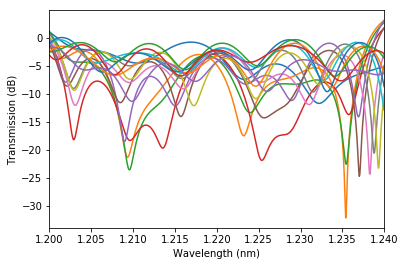

In [17]:
spectra.crop([1.2, 1.24]).simplePlot()